### Task 6

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

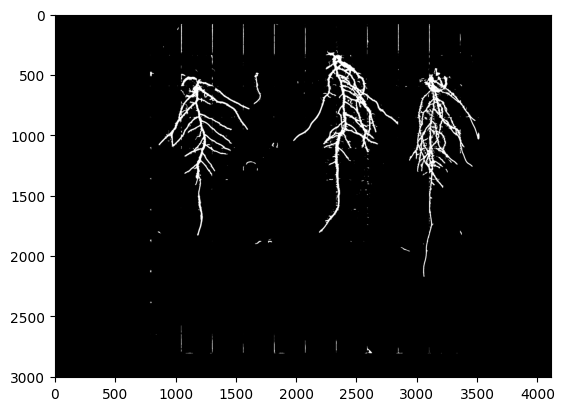

In [2]:
# Step 1: Load the predicted mask from Task 5
predicted_mask_path = "task5_test_image_prediction_artjom_234535.png"
binary_mask = cv2.imread(predicted_mask_path, cv2.IMREAD_GRAYSCALE)

# Ensure binary mask (0 or 255)
binary_mask[binary_mask > 0] = 255

plt.imshow(binary_mask, cmap="gray")

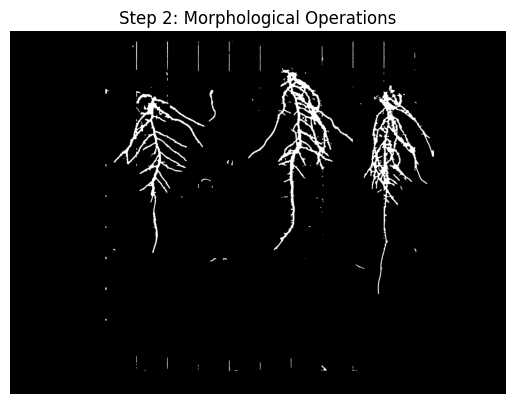

In [3]:
# Step 2: Apply morphological operations to clean the mask
kernel = np.ones((4, 4), np.uint8)
cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=2)  # Close small gaps
cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel, iterations=1)  # Remove small noise

plt.figure()
plt.title("Step 2: Morphological Operations")
plt.imshow(cleaned_mask, cmap="gray")
plt.axis("off")
plt.show()

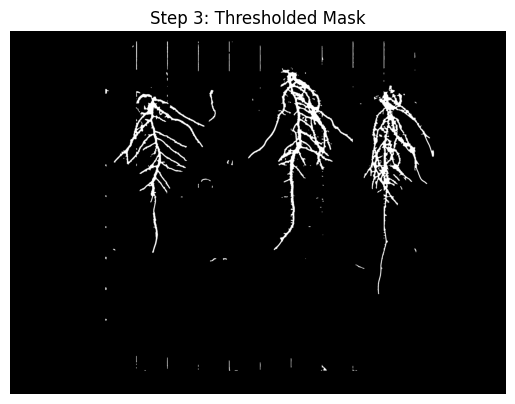

In [4]:
# Step 3: Apply additional thresholding to enhance roots
_, thresholded_mask = cv2.threshold(cleaned_mask, 127, 255, cv2.THRESH_BINARY)

plt.figure()
plt.title("Step 3: Thresholded Mask")
plt.imshow(thresholded_mask, cmap="gray")
plt.axis("off")
plt.show()

In [5]:
# Step 4: Find connected components and filter
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresholded_mask)

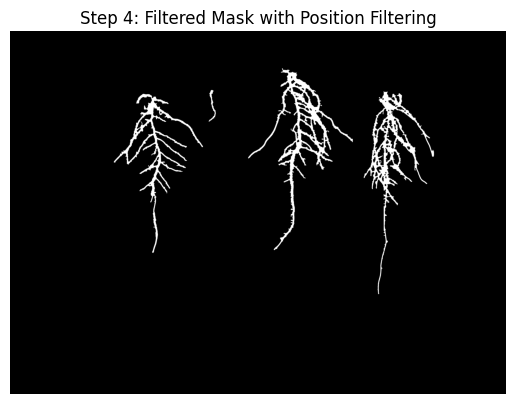

In [6]:
# Step 5: Filter objects based on area, aspect ratio, and position
min_root_area = 1500  # Minimum area to consider an object as a root
aspect_ratio_threshold = 1.7  # Minimum aspect ratio (length/width) for roots

y_threshold = 100  # Exclude components too close to the top

filtered_mask = np.zeros_like(binary_mask, dtype=np.uint8)

for label_idx in range(1, num_labels):  # Skip background (label 0)
    x, y, w, h, area = stats[label_idx, cv2.CC_STAT_LEFT], stats[label_idx, cv2.CC_STAT_TOP], \
                       stats[label_idx, cv2.CC_STAT_WIDTH], stats[label_idx, cv2.CC_STAT_HEIGHT], \
                       stats[label_idx, cv2.CC_STAT_AREA]

    # Calculate aspect ratio (length/width)
    aspect_ratio = max(w, h) / min(w, h) if min(w, h) > 0 else 0

    # Filter based on area, aspect ratio, and position
    if area >= min_root_area and aspect_ratio >= aspect_ratio_threshold:
        # Additional filter to remove components near the top boundary
        if y > y_threshold:  # Adjust this threshold as needed
            filtered_mask[labels == label_idx] = 255

# Apply small morphological operations to remove tiny noise
final_kernel = np.ones((3, 3), np.uint8)
filtered_mask = cv2.morphologyEx(filtered_mask, cv2.MORPH_OPEN, final_kernel, iterations=1)

plt.figure()
plt.title("Step 4: Filtered Mask with Position Filtering")
plt.imshow(filtered_mask, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
# Step 6: Extract individual roots
num_labels_filtered, labels_filtered, stats_filtered, _ = cv2.connectedComponentsWithStats(filtered_mask)

individual_roots = []
for label_idx in range(1, num_labels_filtered):  # Skip background
    root_mask = np.zeros_like(filtered_mask, dtype=np.uint8)
    root_mask[labels_filtered == label_idx] = 255
    individual_roots.append(root_mask)

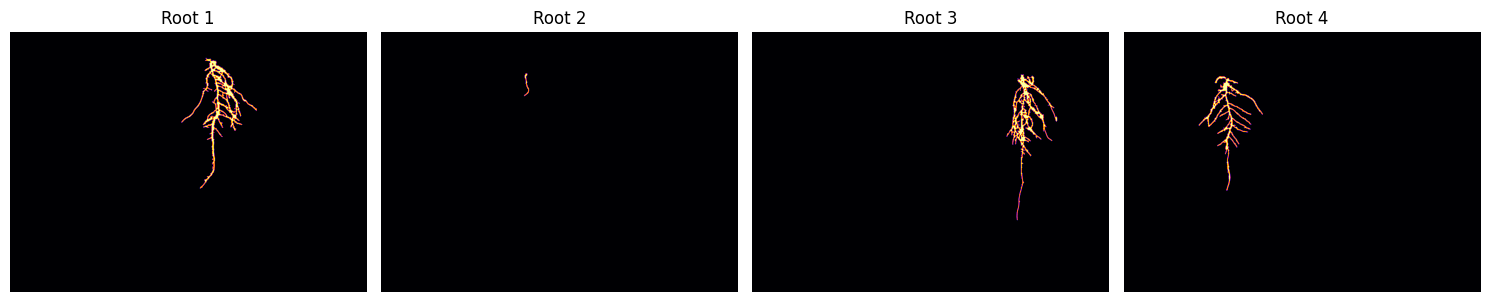

In [8]:
# Step 7: Visualize individual roots
fig, axes = plt.subplots(1, len(individual_roots), figsize=(15, 5))
for i, root_mask in enumerate(individual_roots):
    axes[i].imshow(root_mask, cmap="inferno")
    axes[i].axis("off")
    axes[i].set_title(f"Root {i+1}")
plt.tight_layout()
plt.show()

### Task 7

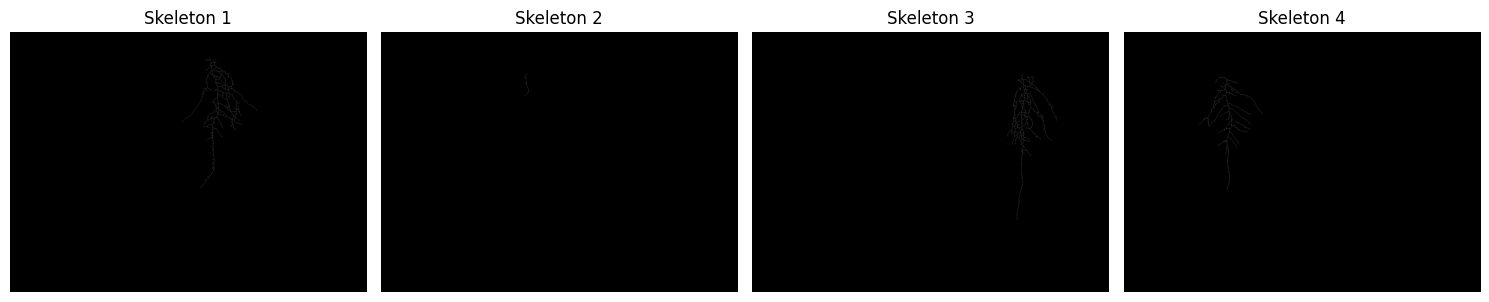

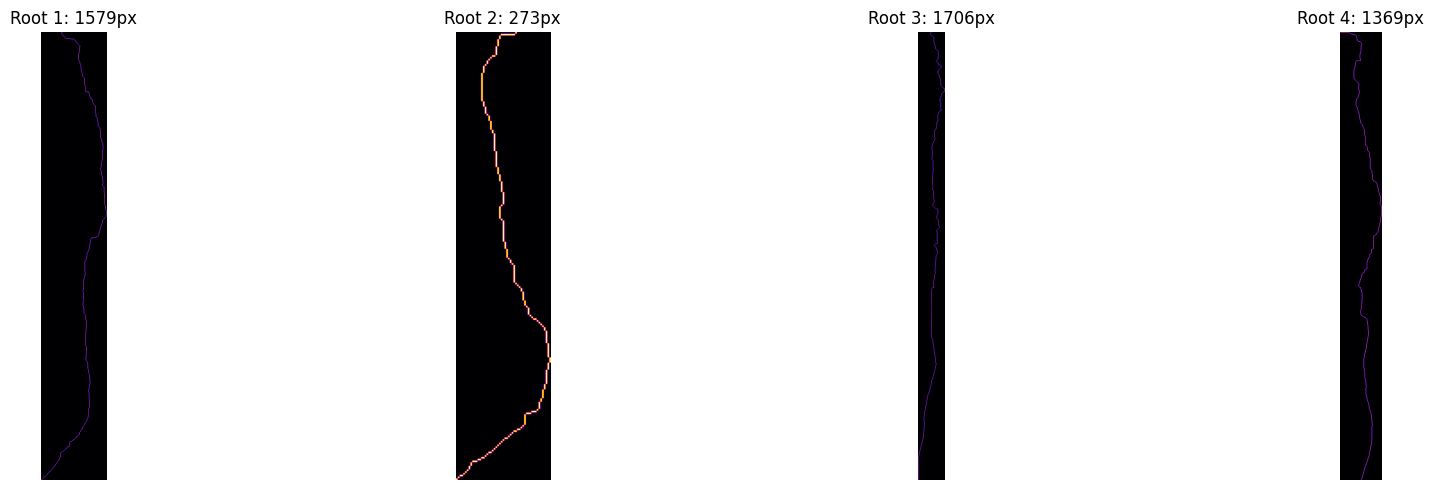

   Root Index  Primary Root Length (px) Start Coordinate End Coordinate
0           1                      1579      (311, 2257)   (1810, 2190)
1           2                       273      (496, 1682)    (747, 1649)
2           3                      1706      (498, 3100)   (2177, 3054)
3           4                      1369      (532, 1125)   (1829, 1184)


In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from skimage.morphology import skeletonize
import pandas as pd

# Step 1: Skeletonize the root masks
skeletons = [skeletonize((root_mask > 0).astype(np.uint8)) for root_mask in individual_roots]

# Visualize skeletons
fig, axes = plt.subplots(1, len(skeletons), figsize=(15, 5))
for i, skeleton in enumerate(skeletons):
    axes[i].imshow(skeleton, cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Skeleton {i+1}")
plt.tight_layout()
plt.show()

# Step 2: Extract Root System Architecture
rsa_data = []
fig, axes = plt.subplots(1, len(skeletons), figsize=(20, 5))

for i, skeleton in enumerate(skeletons):
    coords = np.column_stack(np.nonzero(skeleton))
    if len(coords) == 0:
        print(f"Root {i + 1} contains no skeleton pixels.")
        continue

    # Create graph using coordinates
    G = nx.Graph()
    coord_to_node = {tuple(coord): idx for idx, coord in enumerate(coords)}
    for coord in coords:
        y, x = coord
        G.add_node(coord_to_node[tuple(coord)], coord=(y, x))
        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
            neighbor = (y + dy, x + dx)
            if neighbor in coord_to_node:
                G.add_edge(coord_to_node[tuple(coord)], coord_to_node[neighbor])

    # Find the longest path
    start_node = min(G.nodes, key=lambda n: G.nodes[n]["coord"][0])
    lengths, paths = nx.single_source_dijkstra(G, start_node)
    end_node = max(lengths, key=lengths.get)

    primary_path = paths[end_node]
    primary_length = lengths[end_node]

    # Create mask for primary root
    primary_root_mask = np.zeros_like(skeleton, dtype=np.uint8)
    for node in primary_path:
        y, x = G.nodes[node]["coord"]
        primary_root_mask[y, x] = 255

    # Crop image dynamically to root size
    y_coords, x_coords = np.nonzero(primary_root_mask)
    if len(y_coords) > 0 and len(x_coords) > 0:
        cropped_mask = primary_root_mask[min(y_coords):max(y_coords)+1, min(x_coords):max(x_coords)+1]
    else:
        cropped_mask = primary_root_mask

    # Visualize primary root
    axes[i].imshow(cropped_mask, cmap="inferno")
    axes[i].set_title(f"Root {i+1}: {int(primary_length)}px")
    axes[i].axis("off")

    # Save RSA data
    rsa_data.append({
        "Root Index": i + 1,
        "Primary Root Length (px)": primary_length,
        "Start Coordinate": G.nodes[start_node]["coord"],
        "End Coordinate": G.nodes[end_node]["coord"],
    })

plt.tight_layout()
plt.show()

# Step 3: Display RSA data as a table
rsa_df = pd.DataFrame(rsa_data)
print(rsa_df)